# ST590 Project 3

Group 10<br>
Fei Chen (fchen22@ncsu.edu)<br>
Chien-Lan Hsueh (chsueh2@ncsu.edu)

### Preparation

In [31]:
# import the modules and set up environment variables
import os, sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.pandas as ps
ps.options.plotting.backend = "matplotlib"

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import SQLTransformer, StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import plotly
#plotly.io.renderers.default = "notebook_connected"
#import seaborn as sns

In [32]:
# create a spark session
spark = SparkSession.builder.getOrCreate()

In [33]:
# read in the data
df_raw = spark.read.csv(
    path = "online_shoppers_intention.csv",
    sep = ",",
    header = True,
    inferSchema = True,
    )

# take a look at the data - terrible look
#df_raw.show()

# take a look at the data - print nicely by converting to pandas dataframe
df_raw.limit(5).toPandas().transpose()

,0,1,2,3,4
Administrative,0,0,0,0,0
Administrative_Duration,0.0,0.0,0.0,0.0,0.0
Informational,0,0,0,0,0
Informational_Duration,0.0,0.0,0.0,0.0,0.0
ProductRelated,1,2,1,2,10
ProductRelated_Duration,0.0,64.0,0.0,2.666667,627.5
BounceRates,0.2,0.0,0.2,0.05,0.02
ExitRates,0.2,0.1,0.2,0.14,0.05
PageValues,0.0,0.0,0.0,0.0,0.0
SpecialDay,0.0,0.0,0.0,0.0,0.0


In [34]:
# show the schema of the dataframe
df_raw.printSchema()

# save columns and show dimension of the dataframe 
cols = df_raw.columns
print(f"There are {df_raw.count()} rows and {len(cols)} columns.")

# save column groups - response, numeric predictors and categorical predictors
cols_repsonse, cols_num, cols_cat = [cols[-1]], cols[:10], cols[10:-1]
print(
    f"\n"   
    f"Response variable: {cols_repsonse}\n"
    f"Numeric predictors: {cols_num}\n"
    f"Categorical predictors: {cols_cat}")

root
 |-- Administrative: integer (nullable = true)
 |-- Administrative_Duration: double (nullable = true)
 |-- Informational: integer (nullable = true)
 |-- Informational_Duration: double (nullable = true)
 |-- ProductRelated: integer (nullable = true)
 |-- ProductRelated_Duration: double (nullable = true)
 |-- BounceRates: double (nullable = true)
 |-- ExitRates: double (nullable = true)
 |-- PageValues: double (nullable = true)
 |-- SpecialDay: double (nullable = true)
 |-- Month: string (nullable = true)
 |-- OperatingSystems: integer (nullable = true)
 |-- Browser: integer (nullable = true)
 |-- Region: integer (nullable = true)
 |-- TrafficType: integer (nullable = true)
 |-- VisitorType: string (nullable = true)
 |-- Weekend: boolean (nullable = true)
 |-- Revenue: boolean (nullable = true)

There are 12330 rows and 18 columns.

Response variable: ['Revenue']
Numeric predictors: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRela

In [38]:
# check if there is any null values
df_raw.select([count(when(col(c).isNull(), c)).alias(c) for c in df_raw.columns]).toPandas().transpose()

,0
Administrative,0
Administrative_Duration,0
Informational,0
Informational_Duration,0
ProductRelated,0
ProductRelated_Duration,0
BounceRates,0
ExitRates,0
PageValues,0
SpecialDay,0


Create train/test splits:

In [36]:
# split the data into a training and test sets
train, test = df_raw.randomSplit([0.8, 0.2], seed = 1)

EDA on train set:

,0,1,2,3,4
summary,count,mean,stddev,min,max
Administrative,9890,2.3290192113245705,3.3317796348309607,0,27
Administrative_Duration,9890,81.40342528679537,178.65216211853033,0.0,3398.75
Informational,9890,0.5161779575328614,1.2958513080126035,0,24
Informational_Duration,9890,35.181482114781744,144.22006992370902,0.0,2549.375
ProductRelated,9890,31.56046511627907,43.89477385973682,0,705
ProductRelated_Duration,9890,1187.913118544349,1925.4413029605716,0.0,63973.52223
BounceRates,9890,0.022344636070273056,0.0488291400331784,0.0,0.2
ExitRates,9890,0.043146599271991104,0.04887519954870215,0.0,0.2
PageValues,9890,5.848702401433472,18.050561187337365,0.0,361.7637419


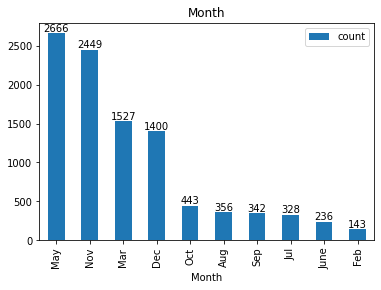

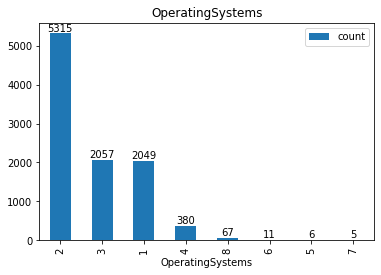

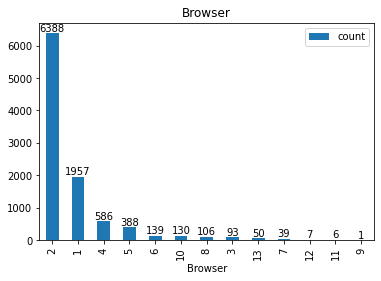

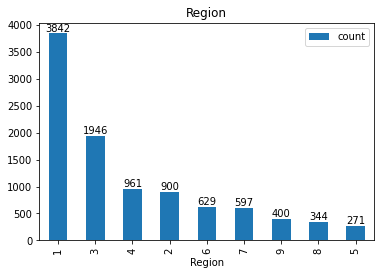

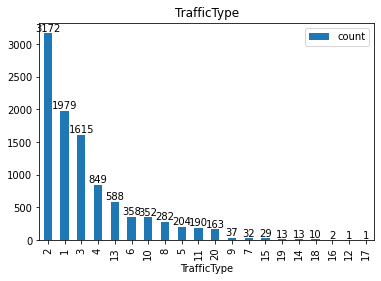

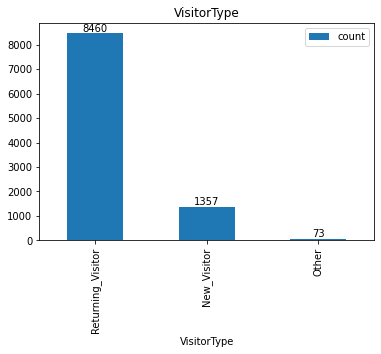

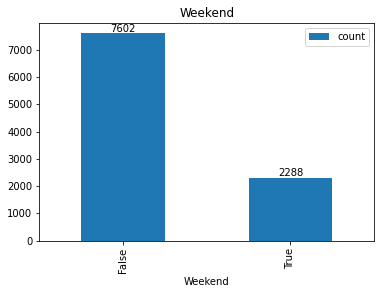

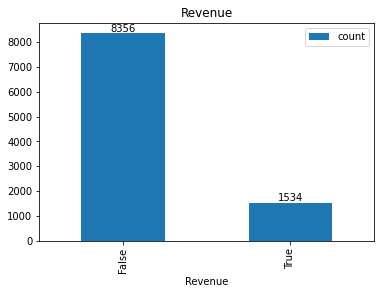

In [37]:
# summary of numeric predictors
display(train.select(cols_num).describe().toPandas().transpose())

# distributions of categorical predictors and response
for x in cols_cat + cols_repsonse:
    df_tmp = train.groupby(x).count().sort(desc("count")).toPandas()    
    #display(df_tmp)
    ax = df_tmp.plot.bar(x = x, y = "count", title = x, xlabel = x)
    ax.bar_label(ax.containers[0])
    plt.show()